In [ ]:
!pip install tensorflow-object-detection-api

In [9]:
!unzip /content/Upload_this.zip

In [ ]:
# Only to download the actual dataset - Size more than 6 GB

"""
# Remove comments to not download: 2014 version coco dataset
!mkdir coco
%cd coco
!mkdir images
%cd images

# Download the images
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!wget http://images.cocodataset.org/zips/test2014.zip

# Unzip the images and remove the zip files
!unzip -q train2014.zip
!unzip -q val2014.zip
!unzip -q test2014.zip
!rm train2014.zip
!rm val2014.zip
!rm test2014.zip

%cd ../
"""

In [10]:
from utils.image_utils import image_saver
import math

is_vehicle_detected = [0]
current_frame_number_list = [0]
current_frame_number_list_2 = [0]
bottom_position_of_detected_vehicle = [0]
recent_speeds = []  # To store recent speeds for a smoother estimate
recent_directions = []
MAX_RECENT_SPEEDS = 5  # Number of recent speeds to consider for averaging
MAX_RECENT_DIRECTIONS = 5

def predict_speed(
    top,
    bottom,
    right,
    left,
    current_frame_number,
    crop_img,
    roi_position,
    camera_angle=45,  # default to 45 degrees
    road_length_in_meters=80  # estimated from the provided description
    ):
    speed = 'n.a.'  # means not available, it is just initialization
    direction = 'n.a.'  # means not available, it is just initialization
    update_csv = False
    isInROI = True  # is the object that is inside Region Of Interest

    # Use the cosine of the camera angle to adjust the scale_constant for the elevation perspective
    scale_constant = (road_length_in_meters / bottom) * math.cos(math.radians(camera_angle)) if bottom != 0 else 1

    # Check for the vehicle detection based on ROI and past detections
    if 195 < bottom_position_of_detected_vehicle[0] < 240 and roi_position < bottom + 100 and (current_frame_number - current_frame_number_list_2[0]) > 30:
        is_vehicle_detected.insert(0, 1)
        update_csv = True
        image_saver.save_image(crop_img)
        current_frame_number_list_2.insert(0, current_frame_number)

    # Determine direction of movement
    if bottom > bottom_position_of_detected_vehicle[0]:
        current_direction = 'down'
    else:
        current_direction = 'up'

    recent_directions.append(current_direction)
    if len(recent_directions) > MAX_RECENT_DIRECTIONS:
        recent_directions.pop(0)
    # Determine the most common direction in recent frames
    direction = max(set(recent_directions), key = recent_directions.count)

    if isInROI:
        pixel_length =bottom - bottom_position_of_detected_vehicle[0]
        real_length = pixel_length * scale_constant  # Convert pixel length to real-world length
        total_time_passed = current_frame_number - current_frame_number_list[0]
        real_time_passed = total_time_passed / 24  # Assuming 24fps for the video

        if real_time_passed != 0:
            speed = abs(real_length / real_time_passed)  # Calculate speed in m/s
            speed = speed * 3.6  # Convert speed to km/h

            # Only append valid speeds
            if isinstance(speed, (int, float)):
                recent_speeds.append(speed)
                if len(recent_speeds) > MAX_RECENT_SPEEDS:
                    recent_speeds.pop(0)

            # Compute median of recent speeds
            if recent_speeds:
                speed =  round(sorted(recent_speeds)[len(recent_speeds) // 2])
            else:
                speed = 0

            current_frame_number_list.insert(0, current_frame_number)
            bottom_position_of_detected_vehicle.insert(0, bottom)


    return (direction, speed, is_vehicle_detected, update_csv)

In [11]:
import os
import csv
import time
import tarfile
import urllib.request
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
from collections import defaultdict
from object_detection.utils import label_map_util, visualization_utils as vis_util

# Initialize .csv
traffic_data_file = 'MeasuresOfTraffic.csv'
data_columns = ['Vehicle ID', 'Type of vehicles/size', 'Color of Vehicles', 'Direction of Vehicle Movement', 'Vehicle Speed (km/h)']
with open(traffic_data_file, 'w', newline='') as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=data_columns)
    csv_writer.writeheader()

# Input video
video_file = 'input.mp4'
video_capture = cv2.VideoCapture(video_file)

# Video properties
video_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
video_fps = int(video_capture.get(cv2.CAP_PROP_FPS))

# Initialize vehicle count
vehicle_count = 0
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

# Model to download
MODEL_NAME = ['faster_rcnn_inception_v2_coco_2018_01_28', 'ssd_mobilenet_v1_coco_2018_01_28']  # Changed to a different model
MODEL_FILE = f"{MODEL_NAME[0]}.tar.gz"
BASE_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/'

# Download and extract models
for model_name in MODEL_NAME:
    if not os.path.exists(model_name):
        urllib.request.urlretrieve(BASE_MODEL_URL + model_name + '.tar.gz', model_name + '.tar.gz')
        tar_file = tarfile.open(model_name + '.tar.gz')
        tar_file.extractall()
        tar_file.close()
        os.remove(model_name + '.tar.gz')

### Cell: To perform operations on video

In [12]:
from datetime import datetime
from sklearn.cluster import KMeans
from utils.color_recognition_module.color_recognition_api import color_recognition
from collections import defaultdict, Counter
from google.protobuf import text_format
import tensorflow.compat.v1 as tf
import cv2
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Initialize visualization data dictionary
visualization_data = {
    'vehicle_types': defaultdict(int),
    'vehicle_speeds': [],
    'vehicle_colors': defaultdict(int)
}

# Initialize trackers dictionary
trackers = {}

# Load the model
PATH_TO_CKPT = MODEL_NAME[0] + '/frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

def load_graph(model_name):
    """
    Load the Tensorflow graph.
    """
    path_to_ckpt = model_name[0] + '/frozen_inference_graph.pb'
    graph = tf.Graph()
    with graph.as_default():
        graph_def = tf.GraphDef()
        with tf.io.gfile.GFile(path_to_ckpt, 'rb') as fid:
            serialized_graph = fid.read()
            graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(graph_def, name='')
    return graph

def load_label_map():
    """
    Load the label map.
    """
    path_to_labels = os.path.join('data', 'mscoco_label_map.pbtxt')
    num_classes = 90
    label_map = label_map_util.string_int_label_map_pb2.StringIntLabelMap()
    with tf.io.gfile.GFile(path_to_labels, 'r') as f:
        label_map_text = f.read()
        text_format.Merge(label_map_text, label_map)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=num_classes, use_display_name=True)
    return label_map_util.create_category_index(categories)

# Initialization
detection_graph = load_graph(MODEL_NAME)
category_index = load_label_map()

out_filename = "output.mp4"
vehicle_counter = defaultdict(int)
counted_vehicles = set()
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(out_filename, fourcc, video_fps, (video_width, video_height))
ref_line_position = int(video_height - video_height * 0.35)
previous_positions = defaultdict(list)
ref_line_visible = True
start_time = datetime.now()
recently_counted = defaultdict(int)
BG_COLOR = (50, 50, 50)  # Dark gray background
TEXT_COLOR = (250, 250, 250)  # White text
PADDING = 10  # Padding around the text
vehicle_id_counter,current_vehicle_id = 0, ""


def draw_text_with_background(image, text, position, font=cv2.FONT_HERSHEY_SIMPLEX, scale=0.5, text_color=(250, 250, 250), bg_color=(50, 50, 50)):
    """Draw text with a background rectangle."""
    (text_width, text_height), _ = cv2.getTextSize(text, font, scale, 1)

    # Draw a background rectangle around the text
    cv2.rectangle(image,
                  (position[0] - PADDING, position[1] - text_height - PADDING),
                  (position[0] + text_width + PADDING, position[1] + PADDING),
                  bg_color,
                  -1)  # -1 indicates filled rectangle

    # Draw the text over the rectangle
    cv2.putText(image, text, position, font, scale, text_color, 1)

    return image, text_height + 2 * PADDING

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        print("[INFO] Tensorflow session started.")
        for frame_num in range(total_frames):
            ret, image_np = video_capture.read()
            if not ret:
                print(f"[WARNING] Frame {frame_num + 1} not available. Moving to the next frame.")
                continue

            # Detecting and annotating vehicles
            image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
            if not ret:
                break

            # Draw the reference line (blinking logic)
            if ref_line_visible:
                cv2.line(image_np, (0, ref_line_position), (video_width, ref_line_position), (0, 0, 255), 2)

            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            # Detection
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})

            # Blinking logic for reference line
            for box in np.squeeze(boxes):
                ymin, xmin, ymax, xmax = box
                midpoint_y = (ymin + ymax) / 2
                if ref_line_position - 0.8 <= int(midpoint_y * video_height) <= ref_line_position + 0.8:
                    ref_line_visible = not ref_line_visible
                    break

            for i, box in enumerate(np.squeeze(boxes)):
                if np.squeeze(scores)[i] > 0.6:
                    ymin, xmin, ymax, xmax = box
                    midpoint_y = (ymin + ymax) / 2  # Moved this line here to ensure it's updated for every box

                    # Changed logic for the reference line's color
                    ref_line_color = (0, 255, 255) if int(midpoint_y * video_height) == ref_line_position else (0, 0, 255)

                    if int(midpoint_y * video_height) == ref_line_position:
                        ref_line_color = (0, 255, 255)  # Color: yellow
                    else:
                        ref_line_color = (0, 0, 255)  # Color: blue

                    # Convert the coordinates to pixel values
                    top = int(ymin * video_height)
                    left = int(xmin * video_width)
                    bottom = int(ymax * video_height)
                    right = int(xmax * video_width)

                    crop_img = image_np[top:bottom, left:right]
                    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR)
                    (direction, speed, _, update_csv) = predict_speed(
                        top, bottom, right, left, frame_num, crop_img, ref_line_position)
                    vehicle_type = category_index[np.squeeze(classes).astype(np.int32)[i]]["name"]
                    color_name = color_recognition(crop_img)
                    speed = float(abs(speed)) if speed and isinstance(speed, str) and speed.replace('.', '', 1).isdigit() else speed
                    # Construct the info text with available entities
                    info_data = [
                        (f"s: {speed} km/h", (left, top-30)),
                        (f"Dir: {direction}", (left, top-20)),
                        (f"Col: {color_name}", (left, top-10))
                    ]

                    image_np = cv2.rectangle(image_np, (left, top), (right, bottom), (0, 255, 0), 2)
                    y_position = top - 30
                    # Inside the loop where you write text:
                    for text, _ in info_data:
                        if text.split(": ")[1].strip():  # Check if the entity is available
                            image_np, height_offset = draw_text_with_background(image_np, text, (left, y_position))
                            y_position -= height_offset  # Move up for the next text
                    vehicle_type = category_index[np.squeeze(classes).astype(np.int32)[i]]["name"]
                    midpoint = ((xmin + xmax) / 2, (ymin + ymax) / 2)
                    vehicle_id = f"{vehicle_type}_{midpoint[0]}_{midpoint[1]}"

                    bottom_position = int(ymax * video_height)
                    previous_bottom_position = previous_positions.get(vehicle_id, None)
                    TOLERANCE = 10

                    # Check if the bottom of the bounding box crosses the reference line
                    if (bottom_position >= ref_line_position - TOLERANCE and bottom_position <= ref_line_position + TOLERANCE) and vehicle_id not in counted_vehicles:
                        vehicle_counter[vehicle_type] += 1
                        vehicle_id_counter += 1
                        current_vehicle_id = f"Vehicle_{vehicle_id_counter}"
                        print(f"[INFO] New {vehicle_type} counted at frame {frame_num + 1}.")
                        counted_vehicles.add(vehicle_id)

                        # Update visualization_data only for newly counted vehicles
                        print(f"[INFO] Detected {vehicle_type}.")
                        visualization_data['vehicle_types'][vehicle_type] += 1
                        visualization_data['vehicle_colors'][color_name] += 1
                        visualization_data['vehicle_speeds'].append(speed)

                    # Update the vehicle's bottom position in the dictionary
                    previous_positions[vehicle_id] = bottom_position


                    # Streamlined CSV saving
                    csv_data = {
                            'Vehicle ID': current_vehicle_id,
                            'Type of vehicles/size': vehicle_type,
                            'Color of Vehicles': color_name,
                            'Direction of Vehicle Movement': direction if direction else 'N/A',
                            'Vehicle Speed (km/h)': f"{speed}" if speed is not None else 'N/A'
                        }
                    with open(traffic_data_file, 'a', newline='') as csv_file:
                            csv_writer = csv.DictWriter(csv_file, fieldnames=data_columns)
                            csv_writer.writerow(csv_data)

                    if vehicle_type in previous_positions:
                        prev_position = previous_positions[vehicle_type][-1]


                    previous_positions[vehicle_type].append(midpoint)
                    # Display the total vehicle count on the video frame
            cv2.putText(image_np, f"Total Vehicle Count: {sum(vehicle_counter.values())}", (10, 20),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2, cv2.LINE_AA)

            image_np_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
            out.write(image_np_bgr)

            if frame_num % 20 == 0:
                print(f"Processing frame {frame_num + 1} of {total_frames}")

video_capture.release()
out.release()
# Display important results
print("\n--- Results ---")
print("Vehicle counts:")
for vehicle_type, count in vehicle_counter.items():
    print(f"{vehicle_type}: {count}")
print(f"\nVehicle types detected: {dict(visualization_data['vehicle_types'])}")
print(f"Vehicle colors detected: {dict(visualization_data['vehicle_colors'])}")
numeric_speeds = [s for s in visualization_data['vehicle_speeds'] if isinstance(s, (int, float))]
avg_speed = sum(numeric_speeds) / len(numeric_speeds) if numeric_speeds else 0
print(f"Average vehicle speed: {avg_speed:.2f} km/h")
print(f"\nVideo processing completed in: {datetime.now() - start_time}")

[INFO] Tensorflow session started.
Processing frame 1 of 538
Processing frame 21 of 538
Processing frame 41 of 538
Processing frame 61 of 538
Processing frame 81 of 538
Processing frame 101 of 538
Processing frame 121 of 538
[INFO] New car counted at frame 132.
[INFO] Detected car.
[INFO] New car counted at frame 133.
[INFO] Detected car.
[INFO] New car counted at frame 134.
[INFO] Detected car.
[INFO] New car counted at frame 135.
[INFO] Detected car.
[INFO] New car counted at frame 136.
[INFO] Detected car.
[INFO] New car counted at frame 137.
[INFO] Detected car.
[INFO] New car counted at frame 138.
[INFO] Detected car.
Processing frame 141 of 538
Processing frame 161 of 538
[INFO] New car counted at frame 179.
[INFO] Detected car.
[INFO] New car counted at frame 180.
[INFO] Detected car.
[INFO] New car counted at frame 181.
[INFO] Detected car.
Processing frame 181 of 538
[INFO] New car counted at frame 183.
[INFO] Detected car.
[INFO] New car counted at frame 184.
[INFO] Detected 

##### **Visualize the statistics**

In [13]:
print("-----Reformatting the video-----")
import moviepy.editor as mpy
# Load the video file
video_clip = mpy.VideoFileClip("output.mp4")
# Re-encode the video to a new format
normalized_video_path = "normalized_video_path.mp4"
video_clip.write_videofile(normalized_video_path, codec='libx264', audio_codec='aac')

-----Reformatting the video-----
Moviepy - Building video normalized_video_path.mp4.
Moviepy - Writing video normalized_video_path.mp4



Moviepy - Done !
Moviepy - video ready normalized_video_path.mp4


In [14]:
# Display the video in the console
from IPython.display import HTML
from base64 import b64encode
import os
video_file = open(normalized_video_path, "rb").read()
video_url = "data:video/mp4;base64," + b64encode(video_file).decode()
HTML(f'<video width="640" height="480" controls><source src="{video_url}" type="video/mp4"></video>')

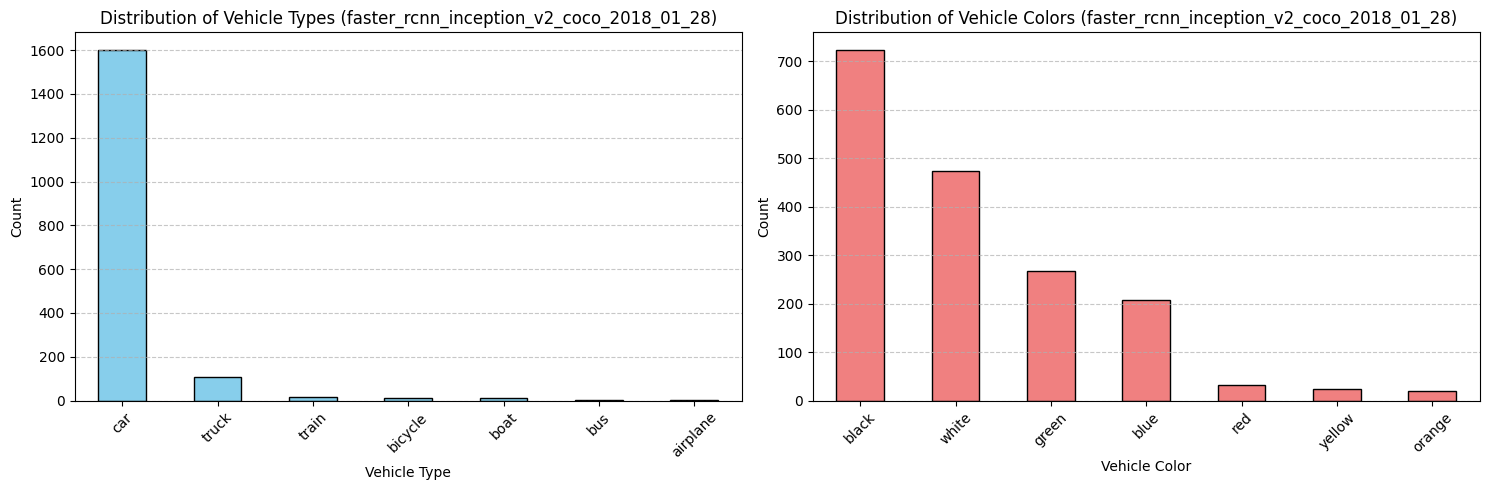

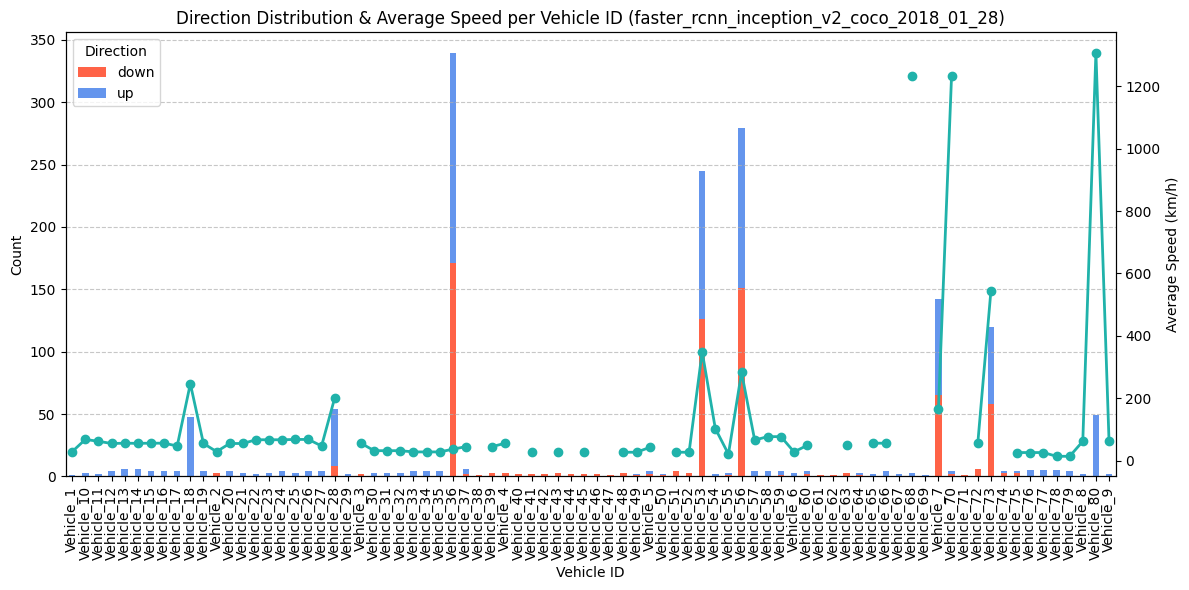

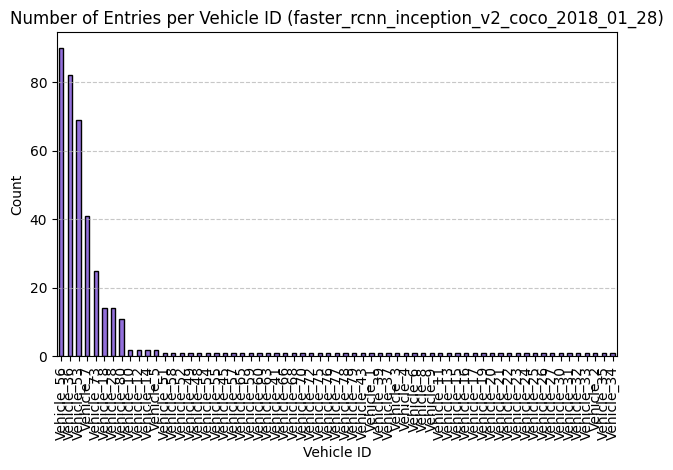

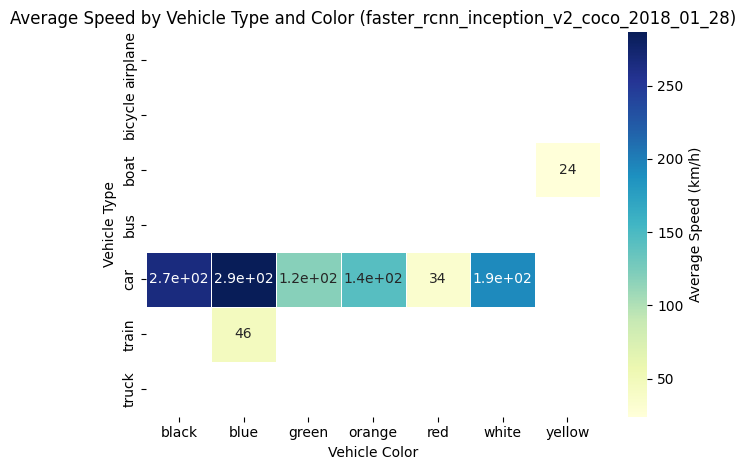

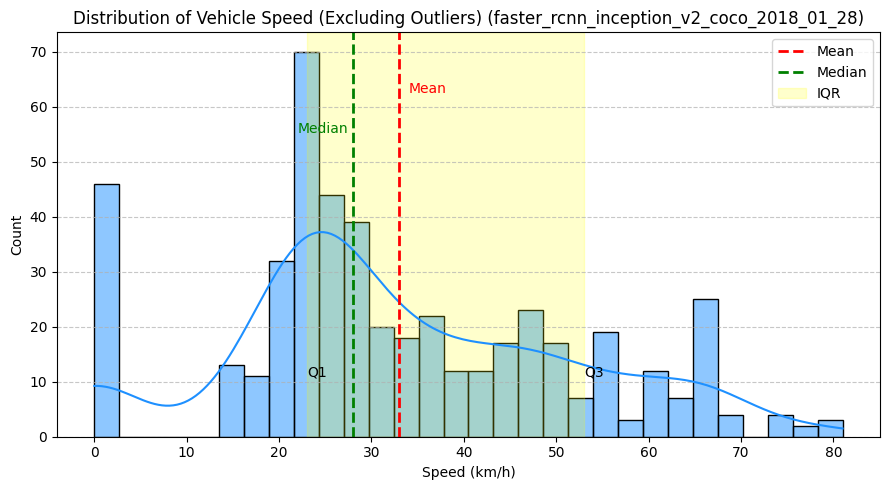

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# Load the CSV file into a DataFrame
df = pd.read_csv('MeasuresOfTraffic.csv')
# Visualization 1: Vehicle Type Distribution
# Set up the figure and axes
def plot_vehicle_distribution(model_name, df):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Visualization 1: Vehicle Type Distribution
    vehicle_type_counts = df['Type of vehicles/size'].value_counts()
    vehicle_type_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=axs[0])
    axs[0].set_title(f'Distribution of Vehicle Types ({model_name})')
    axs[0].set_xlabel('Vehicle Type')
    axs[0].set_ylabel('Count')
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Visualization 2: Vehicle Color Distribution
    vehicle_color_counts = df['Color of Vehicles'].value_counts()
    vehicle_color_counts.plot(kind='bar', color='lightcoral', edgecolor='black', ax=axs[1])
    axs[1].set_title(f'Distribution of Vehicle Colors ({model_name})')
    axs[1].set_xlabel('Vehicle Color')
    axs[1].set_ylabel('Count')
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_combined_visualization(model_name, df):
    # Preparing the data for the combined visualization
    direction_per_vehicle = df.groupby(['Vehicle ID', 'Direction of Vehicle Movement']).size().unstack().fillna(0)
    df['Vehicle Speed (km/h)'] = pd.to_numeric(df['Vehicle Speed (km/h)'], errors='coerce')
    average_speeds_per_vehicle = df.groupby('Vehicle ID')['Vehicle Speed (km/h)'].mean()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar chart for Direction Distribution
    direction_per_vehicle.plot(kind='bar', stacked=True, ax=ax1, color=['tomato', 'cornflowerblue'])
    ax1.set_xlabel('Vehicle ID')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend(title='Direction', loc='upper left')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_title(f'Direction Distribution & Average Speed per Vehicle ID ({model_name})')

    # Line plot for Average Speed using a secondary y-axis
    ax2 = ax1.twinx()
    average_speeds_per_vehicle.plot(kind='line', marker='o', ax=ax2, color='lightseagreen', linewidth=2)
    ax2.set_ylabel('Average Speed (km/h)')

    plt.tight_layout()
    plt.show()

def plot_entries_per_vehicle_id(model_name, df):
    df['Vehicle Speed (km/h)'] = pd.to_numeric(df['Vehicle Speed (km/h)'], errors='coerce')
    df = df.dropna(subset=['Vehicle Speed (km/h)'])
    vehicle_id_counts = df['Vehicle ID'].value_counts()

    vehicle_id_counts.plot(kind='bar', color='mediumpurple', edgecolor='black')
    plt.title(f'Number of Entries per Vehicle ID ({model_name})')
    plt.xlabel('Vehicle ID')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_heatmap_vehicle_type_color(model_name, df):
    heatmap_data = df.groupby(['Type of vehicles/size', 'Color of Vehicles'])['Vehicle Speed (km/h)'].mean().unstack()
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': 'Average Speed (km/h)'})
    plt.title(f'Average Speed by Vehicle Type and Color ({model_name})')
    plt.xlabel('Vehicle Color')
    plt.ylabel('Vehicle Type')

    plt.tight_layout()
    plt.show()

def plot_vehicle_speed_distribution(model_name, df):
    plt.figure(figsize=(9,5))

    # Histogram and KDE
    Q1 = df['Vehicle Speed (km/h)'].quantile(0.25)
    Q3 = df['Vehicle Speed (km/h)'].quantile(0.75)
    IQR = Q3 - Q1
    filtered_data = df[(df['Vehicle Speed (km/h)'] >= Q1 - 1.5 * IQR) & (df['Vehicle Speed (km/h)'] <= Q3 + 1.5 * IQR)]
    sns.histplot(filtered_data['Vehicle Speed (km/h)'], kde=True, bins=30, color='dodgerblue', edgecolor='black')

    plt.axvline(filtered_data['Vehicle Speed (km/h)'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(filtered_data['Vehicle Speed (km/h)'].median(), color='green', linestyle='dashed', linewidth=2, label='Median')
    plt.axvspan(Q1, Q3, color='yellow', alpha=0.2, label='IQR')

    plt.text(filtered_data['Vehicle Speed (km/h)'].mean()+1, plt.gca().get_ylim()[1]*0.85, 'Mean', color='red')
    plt.text(filtered_data['Vehicle Speed (km/h)'].median()-6, plt.gca().get_ylim()[1]*0.75, 'Median', color='green')
    plt.text(Q1, plt.gca().get_ylim()[1]*0.15, 'Q1', color='black')
    plt.text(Q3, plt.gca().get_ylim()[1]*0.15, 'Q3', color='black')

    plt.title(f'Distribution of Vehicle Speed (Excluding Outliers) ({model_name})')
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.show()


model_name = MODEL_NAME[0]
plot_vehicle_distribution(model_name,df)
plot_combined_visualization(model_name, df)
plot_entries_per_vehicle_id(model_name, df)
plot_heatmap_vehicle_type_color(model_name, df)
plot_vehicle_speed_distribution(model_name, df)

##### **Statistics**


```
Model: faster_rcnn_inception_v2_coco_2018_01_28
Skewness: Approximately
0.637
0.637
A positive skewness indicates that the distribution is skewed to the right. This means that there are more vehicles with speeds below the mean than above.
Kurtosis: Approximately
0.976
0.976
A kurtosis value close to 0 indicates that the distribution has a shape similar to a normal distribution. Since our value is close to 1, the distribution is slightly more peaked than a normal distribution.

Number of potential outliers: 28
Outlier values: The values range from speeds like 99 km/h to extreme values like 1650 km/h.


```



In [20]:
# Calculate skewness and kurtosis for 'Vehicle Speed (km/h)'
# Replace "n.a." with NaN and convert the column to numeric
df['Vehicle Speed (km/h)'] = pd.to_numeric(df['Vehicle Speed (km/h)'], errors='coerce')

# Replace values greater than 200 with the median of the column
median_speed = df['Vehicle Speed (km/h)'].median()
df.loc[df['Vehicle Speed (km/h)'] > 200, 'Vehicle Speed (km/h)'] = median_speed
skewness = df['Vehicle Speed (km/h)'].skew()
kurtosis = df['Vehicle Speed (km/h)'].kurt()

skewness, kurtosis

(0.6374493186071085, 0.9762239235592642)

In [21]:
df.describe()

,Vehicle Speed (km/h)
count,536.00000
mean,33.58209
std,18.89837
min,0.00000
25%,23.00000
50%,32.00000
75%,45.00000
max,104.00000




```
Model: faster_rcnn_inception_v2_coco_2018_01_28
(car         1601
 truck        108
 train         15
 bicycle       10
 boat          10
 bus            2
 airplane       1
 Name: Type of vehicles/size, dtype: int64,
 black     724
 white     473
 green     268
 blue      208
 red        32
 yellow     23
 orange     19
 Name: Color of Vehicles, dtype: int64,
 up      978
 down    769
 ,
 )

Vehicle ID: 245 missing entries.
Vehicle Speed (km/h): 1211 missing entries.
```



In [18]:
import subprocess
import json

def get_video_metadata(video_file_path):
    command = [
        'ffprobe',
        '-v', 'quiet',
        '-print_format', 'json',
        '-show_format',
        '-show_streams',
        video_file_path
    ]

    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    return json.loads(result.stdout)

if __name__ == "__main__":
    video_file = 'input.mp4'  # Replace this with the path to your .mp4 file
    metadata = get_video_metadata(video_file)

    # Extracting common details
    print("General Information:")
    print("--------------------")
    print(f"Filename: {metadata['format']['filename']}")
    print(f"Duration: {metadata['format']['duration']} seconds")
    print(f"Bitrate: {metadata['format']['bit_rate']} bps")
    print(f"Size: {metadata['format']['size']} bytes")

    for stream in metadata['streams']:
        print("\n")
        print(f"{stream['codec_type'].capitalize()} Stream:")
        print("--------------------")
        if 'codec_name' in stream:
            print(f"Codec: {stream['codec_name']}")
        if 'width' in stream:
            print(f"Width: {stream['width']} pixels")
        if 'height' in stream:
            print(f"Height: {stream['height']} pixels")
        if 'duration' in stream:
            print(f"Duration: {stream['duration']} seconds")
        if 'bit_rate' in stream:
            print(f"Bitrate: {stream['bit_rate']} bps")
        if 'r_frame_rate' in stream:
            numerator, denominator = stream['r_frame_rate'].split('/')
            fps = float(numerator) / float(denominator)
            print(f"Frame rate: {fps} fps")

General Information:
--------------------
Filename: input.mp4
Duration: 18.093300 seconds
Bitrate: 1316323 bps
Size: 2977080 bytes


Video Stream:
--------------------
Codec: h264
Width: 960 pixels
Height: 540 pixels
Duration: 17.933333 seconds
Bitrate: 1326730 bps
Frame rate: 30.0 fps
